# DMNet Training on SUN RGB-D - Google Colab

**Complete end-to-end training pipeline for Direct Mixing ResNet (DMNet) on Google Colab with A100 GPU**

---

## 📋 Checklist Before Running:

- [ ] **Enable A100 GPU:** Runtime → Change runtime type → Hardware accelerator: GPU → GPU type: A100
- [ ] **Mount Google Drive:** Your code and dataset will be stored on Drive
- [ ] **Upload dataset to Drive:** `MyDrive/datasets/sunrgbd_15/` (preprocessed 15-category dataset)
- [ ] **Expected Runtime:** ~2-3 hours for training

---

## 🎯 What This Notebook Does:

1. ✅ Verify A100 GPU is available
2. ✅ Mount Google Drive
3. ✅ Clone your repository to local disk (fast I/O)
4. ✅ Copy SUN RGB-D dataset to local disk (10-20x faster than Drive)
5. ✅ Install dependencies
6. ✅ Train DMNet (Direct Mixing ResNet) with all optimizations
7. ✅ Save checkpoints to Drive (persistent storage)
8. ✅ Generate training curves and analysis

---

## 🧠 About DMNet:

**DMNet** (Direct Mixing Network) is a 2-stream neural network architecture where:
- **RGB stream** processes color images
- **Depth stream** processes depth maps
- **Integrated Stream** combines both streams using learned scalar mixing weights at every layer

Unlike traditional fusion methods, DMNet performs integration **inside each convolution neuron** through scalar-based direct mixing:
- Per-stream weights (full kernels for RGB and Depth)
- Integrated weight (1×1 channel-wise for integrated features)
- Scalar mixing coefficients (α, γ) learned per layer to combine stream outputs

This allows the network to learn optimal integration strategies at every layer with minimal computational overhead!

---

**Let's get started!** 🚀

## 1. Environment Setup & GPU Verification

In [47]:
# Check GPU availability and specs
import torch
import subprocess

print("=" * 60)
print("GPU VERIFICATION")
print("=" * 60)

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # Check if it's A100
    gpu_name = torch.cuda.get_device_name(0)
    if 'A100' in gpu_name:
        print("\n✅ A100 GPU detected - PERFECT for training!")
    elif 'V100' in gpu_name:
        print("\n✅ V100 GPU detected - Good for training (slower than A100)")
    elif 'T4' in gpu_name:
        print("\n⚠️  T4 GPU detected - Will be slower, consider upgrading to A100")
    else:
        print(f"\n⚠️  GPU: {gpu_name} - Consider using A100 for best performance")
else:
    print("\n❌ NO GPU DETECTED!")
    print("Please enable GPU: Runtime → Change runtime type → Hardware accelerator: GPU")
    raise RuntimeError("GPU is required for training")

print("\n" + "=" * 60)

GPU VERIFICATION
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
GPU Device: NVIDIA A100-SXM4-80GB
GPU Memory: 79.32 GB

✅ A100 GPU detected - PERFECT for training!



In [48]:
# Detailed GPU info
!nvidia-smi

Sat Jan 17 05:45:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   56C    P0             92W /  400W |   27199MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 2. Mount Google Drive

In [49]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

print("\n✅ Google Drive mounted successfully!")
print(f"\nDrive contents:")
!ls -la /content/drive/MyDrive/ | head -20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Google Drive mounted successfully!

Drive contents:
total 3079446
-rw------- 1 root root        176 Sep 21  2019 06-lab2.gdoc
-rw------- 1 root root      21621 Sep 30  2024 113-1363667-3121001@USSR24093000064918@pre-paid.png
-rw------- 1 root root        176 Aug 13  2020 2020 summer final (1).gdoc
-rw------- 1 root root        176 Aug 13  2020 2020 summer final (2).gdoc
-rw------- 1 root root        176 Aug 13  2020 2020 summer final (3).gdoc
-rw------- 1 root root        176 Aug 13  2020 2020 summer final.gdoc
-rw------- 1 root root        176 Jul 11  2025 2025_Gabriel_Clinger_Contractor Agreement_BASE copy.gdoc
-rw------- 1 root root      32204 Apr 18  2022 2900 On First- Welcome Home Next Steps.docx
-rw------- 1 root root       8822 Jun 24  2017 A6.docx
-rw------- 1 root root      22204 Jan 21  2023 activity (1).xlsx
-rw------- 1 root root      22161 Ja

## 3. Clone Repository to Local Disk (Fast I/O)

**Important:** We clone to `/content/` (local SSD) instead of Drive for 10-20x faster I/O

**Default:** Clone from GitHub (recommended - always gets latest code)

In [50]:
import os
from pathlib import Path

# Configuration
PROJECT_NAME = "Multi-Stream-Neural-Networks"
GITHUB_REPO = "https://github.com/clingergab/Multi-Stream-Neural-Networks.git"  # UPDATE THIS
LOCAL_REPO_PATH = f"/content/{PROJECT_NAME}"  # Local copy for fast I/O

print("=" * 60)
print("REPOSITORY SETUP")
print("=" * 60)

# Ensure we're in a valid directory
os.chdir('/content')
print(f"Starting in: {os.getcwd()}")

# Check if repo already exists (same session, rerunning cell)
if Path(LOCAL_REPO_PATH).exists() and Path(f"{LOCAL_REPO_PATH}/.git").exists():
    print(f"\n📁 Repo already exists: {LOCAL_REPO_PATH}")
    print(f"🔄 Pulling latest changes...")

    os.chdir(LOCAL_REPO_PATH)
    !git pull
    print("✅ Repo updated")

# Clone from GitHub (first run)
else:
    # Remove old incomplete copy if exists
    if Path(LOCAL_REPO_PATH).exists():
        print(f"\n🗑️  Removing incomplete repo copy...")
        !rm -rf {LOCAL_REPO_PATH}

    print(f"\n🔄 Cloning from GitHub...")
    print(f"   Repo: {GITHUB_REPO}")
    print(f"   Destination: {LOCAL_REPO_PATH}")

    !git clone {GITHUB_REPO} {LOCAL_REPO_PATH}

    # Verify clone succeeded
    if not Path(LOCAL_REPO_PATH).exists():
        raise RuntimeError(f"Failed to clone repository to {LOCAL_REPO_PATH}")

    print("✅ Repo cloned successfully")
    os.chdir(LOCAL_REPO_PATH)

# Verify repo structure
print(f"\n📂 Repository structure:")
!ls -la {LOCAL_REPO_PATH}

print(f"\n✅ Working directory: {os.getcwd()}")

REPOSITORY SETUP
Starting in: /content

📁 Repo already exists: /content/Multi-Stream-Neural-Networks
🔄 Pulling latest changes...
Already up to date.
✅ Repo updated

📂 Repository structure:
total 88
drwxr-xr-x 12 root root  4096 Jan 16 20:49 .
drwxr-xr-x  1 root root  4096 Jan 16 20:49 ..
drwxr-xr-x  5 root root  4096 Jan 16 20:49 configs
drwxr-xr-x  2 root root  4096 Jan 16 20:49 data
-rw-r--r--  1 root root  4003 Jan 16 20:49 dmconv_memory_optimization.md
drwxr-xr-x  2 root root  4096 Jan 16 20:49 docs
drwxr-xr-x  3 root root  4096 Jan 16 20:49 experiments
drwxr-xr-x  9 root root  4096 Jan 17 05:45 .git
-rw-r--r--  1 root root   732 Jan 16 20:49 .gitattributes
drwxr-xr-x  3 root root  4096 Jan 16 20:49 .github
-rw-r--r--  1 root root   758 Jan 16 20:49 .gitignore
-rw-r--r--  1 root root  1084 Jan 16 20:49 LICENSE
drwxr-xr-x  2 root root  4096 Jan 16 20:49 notebooks
-rw-r--r--  1 root root   198 Jan 16 20:49 pytest.ini
-rw-r--r--  1 root root  3884 Jan 16 20:49 README.md
-rw-r--r--  1 

## 4. Install Dependencies

In [51]:
# Install required packages
print("Installing dependencies...")

!pip install -q h5py tqdm matplotlib seaborn ray[tune]

# Verify installations
import h5py
import tqdm
import matplotlib
import seaborn
import ray

print("✅ All dependencies installed!")
print(f"   h5py: {h5py.__version__}")
print(f"   matplotlib: {matplotlib.__version__}")
print(f"   ray: {ray.__version__}")

Installing dependencies...
✅ All dependencies installed!
   h5py: 3.15.1
   matplotlib: 3.10.0
   ray: 2.53.0


## 5. Copy SUN RGB-D Dataset to Local Disk

**Performance Note:** Local disk I/O is ~10-20x faster than Drive!

**Dataset:** SUN RGB-D 15-category preprocessed dataset with RGB + Depth (~2.5 GB)

In [52]:
from pathlib import Path
import os

# Paths
DRIVE_DATASET_TAR = "/content/drive/MyDrive/datasets/sunrgbd_15.tar.gz"  # Compressed file (2-stream: RGB + Depth)
LOCAL_DATASET_PATH = "/content/data/sunrgbd_15"  # Extracted location

print("=" * 60)
print("SUN RGB-D 15-CATEGORY DATASET SETUP (2-STREAM: RGB + DEPTH)")
print("=" * 60)

# Check if already on local disk
if Path(LOCAL_DATASET_PATH).exists():
    print(f"✅ Dataset already on local disk: {LOCAL_DATASET_PATH}")

    # Verify structure
    train_rgb_count = len(list(Path(f"{LOCAL_DATASET_PATH}/train/rgb").glob("*.png")))
    val_rgb_count = len(list(Path(f"{LOCAL_DATASET_PATH}/val/rgb").glob("*.png")))
    print(f"   Train samples: {train_rgb_count}")
    print(f"   Val samples: {val_rgb_count}")

# Copy and extract from Drive
elif Path(DRIVE_DATASET_TAR).exists():
    print(f"📁 Found compressed dataset on Drive: {DRIVE_DATASET_TAR}")
    print(f"📥 Copying compressed file to local disk...")

    # Create parent directory
    !mkdir -p /content/data

    # Copy compressed file with progress
    print(f"\nCopying compressed archive...")
    !rsync -ah --info=progress2 {DRIVE_DATASET_TAR} /content/data/sunrgbd_15.tar.gz

    # Extract to local disk (suppress macOS metadata warnings)
    print(f"\n📦 Extracting dataset to local disk...")
    !tar -xzf /content/data/sunrgbd_15.tar.gz -C /content/data/ 2>&1 | grep -v "Ignoring unknown extended header"

    # Remove tar file to save space
    !rm /content/data/sunrgbd_15.tar.gz

    print(f"\n✅ Dataset extracted to local disk")

    # Verify extraction
    train_rgb_count = len(list(Path(f"{LOCAL_DATASET_PATH}/train/rgb").glob("*.png")))
    val_rgb_count = len(list(Path(f"{LOCAL_DATASET_PATH}/val/rgb").glob("*.png")))
    print(f"   Train samples: {train_rgb_count}")
    print(f"   Val samples: {val_rgb_count}")

else:
    print(f"❌ Compressed dataset not found on Drive!")
    print(f"   Expected location: {DRIVE_DATASET_TAR}")
    print(f"\n📋 To fix this:")
    print(f"   1. Run: tar -czf sunrgbd_15.tar.gz -C data sunrgbd_15")
    print(f"   2. Upload sunrgbd_15.tar.gz to Google Drive")
    print(f"   3. Place it at: {DRIVE_DATASET_TAR}")
    raise FileNotFoundError(f"Compressed dataset not found at {DRIVE_DATASET_TAR}")

print("\n" + "=" * 60)
print(f"Dataset ready at: {LOCAL_DATASET_PATH}")
print("=" * 60)

SUN RGB-D 15-CATEGORY DATASET SETUP (2-STREAM: RGB + DEPTH)
✅ Dataset already on local disk: /content/data/sunrgbd_15
   Train samples: 16082
   Val samples: 4036

Dataset ready at: /content/data/sunrgbd_15


## 6. Setup Python Path & Import DMNet

In [53]:
import sys
import os

# Remove cached modules
modules_to_reload = [k for k in sys.modules.keys() if k.startswith('src.')]
for module in modules_to_reload:
    del sys.modules[module]

# Add project to Python path
project_root = '/content/Multi-Stream-Neural-Networks'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Verify project structure
print("Project structure:")
!ls -la {project_root}/src/models/

# Import LiNet and SUN RGB-D dataloader
print("\nImporting LiNet and dataloaders...")
from src.models.linear_integration.li_net3 import li_resnet18
from src.data_utils.sunrgbd_dataset import get_sunrgbd_dataloaders

# Import Ray Tune
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

print("✅ LINet3, dataloaders, and Ray Tune imported successfully!")

Project structure:
total 52
drwxr-xr-x 12 root root 4096 Jan 16 20:51 .
drwxr-xr-x  8 root root 4096 Jan 16 20:51 ..
drwxr-xr-x  3 root root 4096 Jan 16 20:51 abstracts
drwxr-xr-x  3 root root 4096 Jan 16 20:51 common
drwxr-xr-x  3 root root 4096 Jan 16 20:51 core
drwxr-xr-x  2 root root 4096 Jan 16 20:49 direct_mixing_activation
drwxr-xr-x  2 root root 4096 Jan 16 20:49 direct_mixing_bn
drwxr-xr-x  2 root root 4096 Jan 16 20:49 direct_mixing_conv
-rw-r--r--  1 root root 1076 Jan 16 20:49 __init__.py
drwxr-xr-x  5 root root 4096 Jan 16 20:51 linear_integration
drwxr-xr-x  3 root root 4096 Jan 16 20:51 multi_channel
drwxr-xr-x  2 root root 4096 Jan 16 20:51 __pycache__
drwxr-xr-x  2 root root 4096 Jan 16 20:49 utils

Importing LiNet and dataloaders...
✅ LINet3, dataloaders, and Ray Tune imported successfully!


In [54]:
# Set random seed for reproducibility
from src.utils.seed import set_seed

SEED = 42
DETERMINISTIC = False  # False = faster, True = fully reproducible

print("=" * 60)
print("RANDOM SEED CONFIGURATION")
print("=" * 60)

set_seed(SEED, deterministic=DETERMINISTIC)

print(f"\n✅ Seed: {SEED}")
print(f"   Deterministic: {DETERMINISTIC}")
if DETERMINISTIC:
    print("   Mode: Fully reproducible (slower)")
else:
    print("   Mode: Fast reproducible")

print("\n" + "=" * 60)

RANDOM SEED CONFIGURATION

✅ Seed: 42
   Deterministic: False
   Mode: Fast reproducible



## 7. Load SUN RGB-D Dataset

In [55]:
# Verify dataset structure
from pathlib import Path

print("=" * 60)
print("DATASET STRUCTURE VERIFICATION")
print("=" * 60)

dataset_root = Path(LOCAL_DATASET_PATH)

print("\nDirectory structure:")
print(f"  {dataset_root}/")
print(f"    train/")
print(f"      rgb/ - {len(list((dataset_root / 'train' / 'rgb').glob('*.png')))} images")
print(f"      depth/ - {len(list((dataset_root / 'train' / 'depth').glob('*.png')))} images")
print(f"      labels.txt")
print(f"    val/")
print(f"      rgb/ - {len(list((dataset_root / 'val' / 'rgb').glob('*.png')))} images")
print(f"      depth/ - {len(list((dataset_root / 'val' / 'depth').glob('*.png')))} images")
print(f"      labels.txt")
print(f"    class_names.txt")
print(f"    dataset_info.txt")

# Read class names
with open(dataset_root / 'class_names.txt', 'r') as f:
    class_names = [line.strip() for line in f]

print(f"\nClasses ({len(class_names)}):")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

print("\n" + "=" * 60)

DATASET STRUCTURE VERIFICATION

Directory structure:
  /content/data/sunrgbd_15/
    train/
      rgb/ - 16082 images
      depth/ - 16082 images
      labels.txt
    val/
      rgb/ - 4036 images
      depth/ - 4036 images
      labels.txt
    class_names.txt
    dataset_info.txt

Classes (15):
  0: 0: bathroom
  1: 1: bedroom
  2: 2: classroom
  3: 3: computer_room
  4: 4: corridor
  5: 5: dining_area
  6: 6: dining_room
  7: 7: discussion_area
  8: 8: furniture_store
  9: 9: kitchen
  10: 10: lab
  11: 11: library
  12: 12: office
  13: 13: rest_space
  14: 14: study_space



In [56]:
print("=" * 60)
print("LOADING SUN RGB-D 15-CATEGORY DATASET (2-STREAM: RGB + DEPTH)")
print("=" * 60)

# Dataset configuration
DATASET_CONFIG = {
    'data_root': LOCAL_DATASET_PATH,
    'batch_size': 96,  # Good balance for A100
    'num_workers': 4,
    'target_size': (416, 544),
    'num_classes': 15,  # SUN RGB-D merged to 15 categories (labels 0-14)
    'seed': SEED  # For reproducible data loading
}

print(f"Configuration:")
for key, value in DATASET_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nLoading dataset from: {DATASET_CONFIG['data_root']}")

# Create reproducible dataloaders
train_loader, val_loader = get_sunrgbd_dataloaders(
    data_root=DATASET_CONFIG['data_root'],
    batch_size=DATASET_CONFIG['batch_size'],
    num_workers=DATASET_CONFIG['num_workers'],
    target_size=DATASET_CONFIG['target_size'],
    seed=DATASET_CONFIG['seed']  # Pass seed for reproducibility
)

print(f"\n✅ Dataset loaded successfully!")
print(f"\nDataset Statistics:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Train samples: {len(train_loader.dataset)}")
print(f"  Val samples: {len(val_loader.dataset)}")
print(f"  Batch size: {DATASET_CONFIG['batch_size']}")

# Test loading a batch
print(f"\nTesting batch loading...")
rgb_batch, depth_batch, label_batch = next(iter(train_loader))
print(f"  RGB shape: {rgb_batch.shape}")
print(f"  Depth shape: {depth_batch.shape}")
print(f"  Labels shape: {label_batch.shape}")
print(f"  Labels min: {label_batch.min().item()}, max: {label_batch.max().item()}")

print("\n" + "=" * 60)

LOADING SUN RGB-D 15-CATEGORY DATASET (2-STREAM: RGB + DEPTH)
Configuration:
  data_root: /content/data/sunrgbd_15
  batch_size: 96
  num_workers: 4
  target_size: (416, 544)
  num_classes: 15
  seed: 42

Loading dataset from: /content/data/sunrgbd_15
Loaded SUN RGB-D train set: 8041 samples, 15 classes
Loaded SUN RGB-D val set: 2018 samples, 15 classes

DataLoader Info:
  Train batches: 84
  Val batches: 22
  Batch size: 96

✅ Dataset loaded successfully!

Dataset Statistics:
  Train batches: 84
  Val batches: 22
  Train samples: 8041
  Val samples: 2018
  Batch size: 96

Testing batch loading...
  RGB shape: torch.Size([96, 3, 416, 544])
  Depth shape: torch.Size([96, 1, 416, 544])
  Labels shape: torch.Size([96])
  Labels min: 0, max: 14



## 8. Visualize Sample Data

Shows RGB images, depth maps, and scene labels from the dataset

Loading samples from TRAINING set (with augmentation)...

Creating visualization...



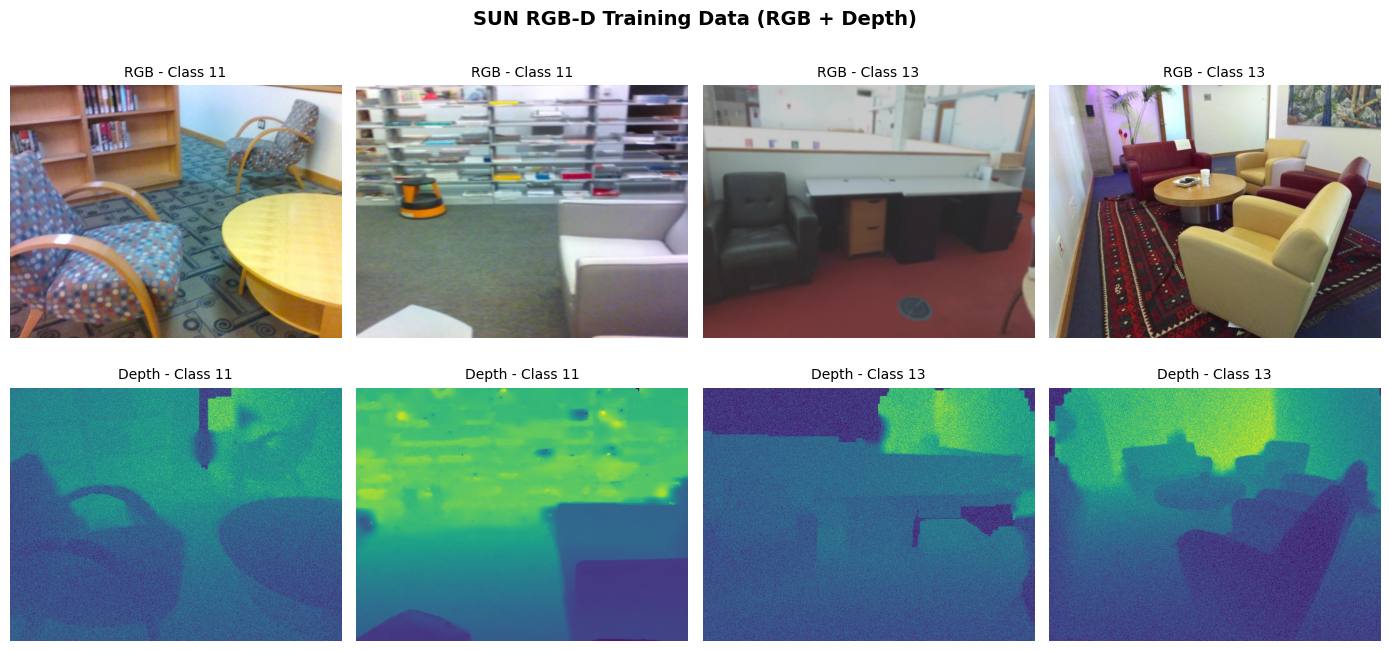

✅ Sample visualization complete!

Note: These are from the TRAINING set (with augmentation).
Augmentations include: random flip, crop, color jitter, blur, and random erasing.


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualize some samples from TRAINING set (WITH augmentation)
# This shows what the model actually sees during training
print("Loading samples from TRAINING set (with augmentation)...")
rgb_batch, depth_batch, label_batch = next(iter(train_loader))

print("\n" + "="*60)
print("Creating visualization...")
print("="*60 + "\n")

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i in range(4):
    rgb = rgb_batch[i].cpu()
    depth = depth_batch[i].cpu()
    label = label_batch[i].item()

    # Denormalize RGB from training statistics
    # RGB stats: mean=[0.4906, 0.4564, 0.4311], std=[0.2794, 0.2869, 0.2922]
    rgb_mean = torch.tensor([0.4906, 0.4564, 0.4311]).view(3, 1, 1)
    rgb_std = torch.tensor([0.2794, 0.2869, 0.2922]).view(3, 1, 1)
    rgb_vis = rgb * rgb_std + rgb_mean

    # Denormalize Depth from training statistics
    # Depth stats: mean=[0.2912], std=[0.1472]
    depth_vis = depth * 0.1472 + 0.2912

    # Clamp to valid range
    rgb_vis = torch.clamp(rgb_vis, 0, 1)
    depth_vis = torch.clamp(depth_vis, 0, 1)

    # Plot RGB
    axes[0, i].imshow(rgb_vis.permute(1, 2, 0))
    axes[0, i].set_title(f"RGB - Class {label}", fontsize=10)
    axes[0, i].axis('off')

    # Plot Depth
    axes[1, i].imshow(depth_vis.squeeze(), cmap='viridis')
    axes[1, i].set_title(f"Depth - Class {label}", fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('SUN RGB-D Training Data (RGB + Depth)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")
print("\nNote: These are from the TRAINING set (with augmentation).")
print("Augmentations include: random flip, crop, color jitter, blur, and random erasing.")

## 8b. Hyperparameter Tuning with Ray Tune (Optional)

Perform a wide search for optimal hyperparameters using Ray Tune.
- **Parallel Trials:** Run multiple configurations simultaneously
- **Data Subset:** Use 50% of data for fast iteration
- **Short Duration:** Train for 10 epochs per trial
- **ASHA Scheduler:** Early stopping for bad trials
- **Uses fit() method:** Ensures consistency with main training (no custom training loop!)

In [58]:
# import ray
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler
# import torch
# from src.models.linear_integration.li_net3 import li_resnet18
# from src.training.optimizers import create_stream_optimizer
# from src.training.schedulers import setup_scheduler
# from src.data_utils.sunrgbd_dataset import get_sunrgbd_dataloaders

# EPOCHS = 50
# class RayTuneReporter:
#     """Callback for reporting metrics to Ray Tune during training."""

#     def __init__(self):
#         self.best_accuracy = 0.0
#         self.best_loss = float('inf')

#     def on_epoch_end(self, epoch, logs):
#         """Report current AND best metrics to Ray Tune."""
#         # Track best metrics
#         if logs['val_accuracy'] > self.best_accuracy:
#             self.best_accuracy = logs['val_accuracy']
#         if logs['val_loss'] < self.best_loss:
#             self.best_loss = logs['val_loss']

#         # Report both current and best metrics
#         tune.report({
#             "accuracy": logs['val_accuracy'],        # Current epoch
#             "loss": logs['val_loss'],                # Current epoch
#             "best_accuracy": self.best_accuracy,     # Best so far ✅
#             "best_loss": self.best_loss,             # Best so far ✅
#             "train_loss": logs['train_loss'],
#             "train_accuracy": logs['train_accuracy']
#         })


# def train_linet_tune(config, train_dataset=None, val_dataset=None):
#     """
#     Trainable function for Ray Tune using fit() method.

#     Benefits of using fit() instead of custom loop:
#     - Reuses all battle-tested training logic from dm_net.py
#     - Consistent behavior between main training and hyperparameter tuning
#     - Proper scheduler stepping, AMP handling, gradient clipping
#     - Single source of truth - no code duplication

#     Args:
#         config: Ray Tune configuration dict with hyperparameters
#         train_dataset: Pre-loaded training dataset (passed via tune.with_parameters)
#         val_dataset: Pre-loaded validation dataset (passed via tune.with_parameters)
#     """
#     # 1. Create dataloaders from pre-loaded datasets
#     # Datasets are created ONCE before tuning starts, then shared across all trials
#     # This avoids redundant I/O and preprocessing for each trial

#     # Create 50% subset for faster hyperparameter evaluation
#     subset_fraction = 1
#     train_indices = torch.randperm(len(train_dataset))[:int(len(train_dataset) * subset_fraction)]
#     val_indices = torch.randperm(len(val_dataset))[:int(len(val_dataset) * subset_fraction)]

#     train_subset = torch.utils.data.Subset(train_dataset, train_indices)
#     val_subset = torch.utils.data.Subset(val_dataset, val_indices)

#     # Create subset dataloaders
#     train_loader = torch.utils.data.DataLoader(
#         train_subset,
#         batch_size=config["batch_size"],
#         shuffle=True,
#         num_workers=2,  # Reduced for parallel trials
#         pin_memory=True
#     )
#     val_loader = torch.utils.data.DataLoader(
#         val_subset,
#         batch_size=config["batch_size"],
#         shuffle=False,
#         num_workers=2,  # Reduced for parallel trials
#         pin_memory=True
#     )

#     # 2. Create Model (2-stream: RGB + Depth)
#     model = li_resnet18(
#         num_classes=15,
#         stream_input_channels=[3, 1],  # RGB=3, Depth=1
#         dropout_p=config["dropout_p"],
#         device="cuda",
#         use_amp=True
#     )

#     # 3. Create Optimizer with stream-specific learning rates
#     optimizer = create_stream_optimizer(
#         model,
#         optimizer_type=config["optimizer_type"],
#         stream_lrs=[config["lr_rgb"], config["lr_depth"]],
#         stream_weight_decays=[config["wd_rgb"], config["wd_depth"]],
#         shared_lr=config["lr_shared"],
#         shared_weight_decay=config["wd_shared"]
#     )

#     # # 4. Create Scheduler
#     # scheduler_kwargs = {}
#     # if config["scheduler_type"] == 'cosine':
#     #     scheduler_kwargs['eta_min'] = config["eta_min"]
#     # elif config["scheduler_type"] == 'plateau':
#     #     scheduler_kwargs['patience'] = config.get("patience", 3)

#     # Disable warmup for Plateau scheduler (incompatible with SequentialLR)
#     warmup_epochs = 5

#     scheduler = setup_scheduler(
#         optimizer,
#         scheduler_type=config["scheduler_type"],
#         eta_min=[config['s1_eta_min'], config['s2_eta_min'], config['eta_min']],
#         epochs=config['t_max'],
#         t_max=config['t_max'],
#         train_loader_len=len(train_loader),
#         warmup_epochs=warmup_epochs,
#         warmup_start_factor=0.2
#     )

#     # 5. Compile model (Keras-style API)
#     model.compile(
#         optimizer=optimizer,
#         scheduler=scheduler,
#         loss='cross_entropy',
#         label_smoothing=config["label_smoothing"]
#     )

#     # 6. Train using fit() with Ray Tune callback
#     # This reuses ALL the training logic from dm_net.py:
#     # - Proper scheduler stepping (OneCycleLR, Plateau, etc.)
#     # - AMP handling with scaler
#     # - Gradient clipping
#     # - Progress tracking
#     model.fit(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         epochs=config["epochs"],
#         early_stopping=True,
#         patience=12,
#         grad_clip_norm=config["grad_clip_norm"],
#         callbacks=[RayTuneReporter()],
#         verbose=False
#     )

In [59]:
# # Initialize Ray
# from ray.tune.search.hyperopt import HyperOptSearch
# from ray.tune.search import ConcurrencyLimiter
# ray.shutdown()  # Clean shutdown of any previous Ray instance
# ray.init(ignore_reinit_error=True)

# # STAGE 2: REFINED SEARCH SPACE (Based on Top 3 from Stage 1)
# # Narrowing ranges around top-performing configurations
# search_space = {
#     # Learning rates - tighter ranges based on top 3
#     "lr_rgb": tune.choice([2e-5, 3e-5]),      # Top 3: 1.49e-04 to 2.79e-04
#     "lr_depth": tune.choice([9e-5, 1e-4, 2e-4]),    # Top 3: 1.05e-04 to 4.53e-04
#     "lr_shared": tune.choice([8e-6, 9e-6, 1e-5]),   # Top 3: 5.20e-04 to 7.71e-03 (wide range)

#     # Weight decay - tighter ranges based on top 3
#     "wd_rgb": tune.choice([6e-5, 7e-5, 8e-5, 9e-5, 1e-4]),      # Top 3: 2.52e-05 to 8.79e-05
#     "wd_depth": tune.choice([8e-5, 9e-5, 1e-4]),    # Top 3: 1.20e-05 to 5.89e-05
#     "wd_shared": tune.choice([9e-4, 1e-3]),   # Top 3: 1.04e-05 to 5.08e-05

#     # Optimizer - focus on top performers
#     "optimizer_type": tune.choice(['adamw']),  # Both showed good results

#     # Scheduler - all used cosine
#     "scheduler_type": tune.choice(['cosine']),
#     "s1_eta_min": tune.choice([1e-7, 2e-7, 3.0e-7, 4e-7, 5e-7]),
#     "s2_eta_min": tune.choice([5.0e-7, 6e-7, 7e-7, 8e-7]),
#     "eta_min": tune.choice([8e-8, 9e-8, 1e-7, 2e-7]),     # Top 3: 1.16e-07 to 6.13e-06

#     # Regularization - explore around top performers
#     "dropout_p": tune.choice([0.4, 0.5, 0.6]),           # Top 3: 0.068 to 0.342
#     "label_smoothing": tune.choice([0.02, 0.03, 0.04, 0.05]),
#     "grad_clip_norm": tune.choice([1, 1.1, 1.2]),       # Top 3: 0.5 and 1.0

#     # Batch size - all top 3 used 64
#     "batch_size": tune.choice([96]),
#     "epochs": tune.choice([95, 100]),
#     "t_max": tune.choice([90, 95])
# }

# print("=" * 60)
# print("STAGE 2: REFINED SEARCH SPACE (2-STREAM: RGB + DEPTH)")
# print("=" * 60)
# print("\nPer-Stream Learning Rates (narrowed):")
# print("  lr_rgb:    log-uniform [1.5e-4, 2.8e-4]  (Top 3: 1.49e-04 to 2.79e-04)")
# print("  lr_depth:  log-uniform [1.0e-4, 4.5e-4]  (Top 3: 1.05e-04 to 4.53e-04)")
# print("\nShared/Integrated:")
# print("  lr_shared: log-uniform [5.0e-4, 8.0e-3]  (Top 3: 5.20e-04 to 7.71e-03)")
# print("\nPer-Stream Weight Decay (narrowed):")
# print("  wd_rgb:    log-uniform [2.5e-5, 9.0e-5]  (Top 3: 2.52e-05 to 8.79e-05)")
# print("  wd_depth:  log-uniform [1.2e-5, 6.0e-5]  (Top 3: 1.20e-05 to 5.89e-05)")
# print("  wd_shared: log-uniform [1.0e-5, 5.0e-5]  (Top 3: 1.04e-05 to 5.08e-05)")
# print("\nOptimizer & Scheduler:")
# print("  optimizer_type:   ['adam', 'adamw']       (Locked - both top performers)")
# print("  scheduler_type:   ['cosine']              (Locked - all top 3 used this)")
# print("  eta_min:          log-uniform [1.0e-7, 6.0e-6]  (Top 3: 1.16e-07 to 6.13e-06)")
# print("\nRegularization:")
# print("  dropout_p:        uniform [0.05, 0.35]    (Top 3: 0.068 to 0.342)")
# print("  label_smoothing:  uniform [0.0, 0.2]")
# print("  grad_clip_norm:   [0.5, 1.0]              (Locked - top 3 used these)")
# print("\nBatch Size:")
# print("  batch_size:       [64]                    (Locked - all top 3 used 64)")
# print("\n" + "=" * 60)

# print("\n🚀 OPTIMIZATION: Creating datasets ONCE instead of 500 times")
# print("   - Shared across all trials for efficiency")
# print("   - Avoids redundant I/O and preprocessing\n")

# hyperopt_searcher = HyperOptSearch(
#     metric="accuracy",
#     mode="max"
# )

# # This explicitly tells Ray Tune to only run 4 trials at once
# limited_search_alg = ConcurrencyLimiter(
#     hyperopt_searcher,
#     max_concurrent=3
# )

# # Create datasets ONCE before tuning starts
# # These will be shared across all trials via tune.with_parameters()
# train_loader_shared, val_loader_shared = get_sunrgbd_dataloaders(
#     data_root=LOCAL_DATASET_PATH,
#     batch_size=64,
#     num_workers=2,
#     target_size=(416, 544)
# )

# # Extract the underlying datasets (not the DataLoaders)
# train_dataset_shared = train_loader_shared.dataset
# val_dataset_shared = val_loader_shared.dataset

# print(f"✅ Datasets created successfully!")
# print(f"   Training samples: {len(train_dataset_shared):,}")
# print(f"   Validation samples: {len(val_dataset_shared):,}")
# print(f"   These will be reused across all trials\n")

# print("=" * 60)
# print("STARTING HYPERPARAMETER TUNING")
# print("=" * 60)
# print("\n💡 Running 20 trials in parallel for maximum GPU utilization")
# print(f"   Each trial: ~4 GB GPU memory")
# print(f"   Total: ~80 GB / 80 GB available")
# print(f"   20x speedup compared to sequential execution!")
# print(f"   Total trials: 500")
# print(f"   Estimated time: ~5-8 hours with early stopping\n")

# # Configure Tuner
# # Pass shared datasets to ALL trials via tune.with_parameters()
# # This avoids creating datasets 500 times (once per trial)
# tuner = tune.Tuner(
#     tune.with_resources(
#         tune.with_parameters(
#             train_linet_tune,
#             train_dataset=train_dataset_shared,  # Shared dataset
#             val_dataset=val_dataset_shared        # Shared dataset
#         ),
#         resources={"cpu": 4, "gpu": 0.333}  # Each trial gets 1/20 GPU
#     ),
#     param_space=search_space,
#     tune_config=tune.TuneConfig(
#         metric="best_accuracy",
#         mode="max",
#         # scheduler=ASHAScheduler(
#         #     max_t=EPOCHS,
#         #     grace_period=10,
#         #     reduction_factor=2
#         # ),
#         search_alg=limited_search_alg,
#         num_samples=15,  # 500 trials for thorough search
#         # max_concurrent_trials=5  # PARALLEL: Run 20 trials at once for 20x speedup!
#     )
# )

# # Run Tuning with custom progress reporter
# results = tuner.fit()

# # Get Best Result
# best_result = results.get_best_result("accuracy", "max")

# print("\n" + "=" * 60)
# print("TUNING COMPLETE")
# print("=" * 60)
# print(f"Best Trial Config: {best_result.config}")
# print(f"Best Trial Accuracy: {best_result.metrics['accuracy']:.4f}")
# print(f"Best Trial Loss: {best_result.metrics['loss']:.4f}")

# print("\n📋 COPY THIS CONFIGURATION TO THE NEXT CELL:")
# print("-" * 40)
# print("STREAM_SPECIFIC_CONFIG = {")
# print(f"    'stream_lrs': [{best_result.config['lr_rgb']:.2e}, {best_result.config['lr_depth']:.2e}],")
# print(f"    'stream_weight_decays': [{best_result.config['wd_rgb']:.2e}, {best_result.config['wd_depth']:.2e}],")
# print(f"    'shared_lr': {best_result.config['lr_shared']:.2e},")
# print(f"    'shared_weight_decay': {best_result.config['wd_shared']:.2e}")
# print("}")
# print("-" * 40)
# print(f"Recommended Optimizer: {best_result.config['optimizer_type']}")
# print(f"Recommended Scheduler: {best_result.config['scheduler_type']}")
# if best_result.config['scheduler_type'] == 'cosine':
#     print(f"Recommended Eta Min: {best_result.config['eta_min']:.2e}")
# elif best_result.config['scheduler_type'] == 'plateau':
#     print(f"Recommended Patience: {best_result.config['patience']}")
# print(f"Recommended Grad Clip: {best_result.config['grad_clip_norm']}")
# print(f"Recommended Label Smoothing: {best_result.config['label_smoothing']}")
# print(f"Recommended Dropout: {best_result.config['dropout_p']}")
# print(f"Recommended Batch Size: {best_result.config['batch_size']}")

# print("\n⚠️ IMPORTANT: Please also update MODEL_CONFIG (dropout), DATASET_CONFIG (batch_size),")
# print("   and TRAIN_CONFIG (grad_clip_norm) with the recommended values above!")


In [60]:
# # Analyze Top 10 Trials from Ray Tune
# import pandas as pd

# print("=" * 80)
# print("TOP 10 TRIALS BY ACCURACY")
# print("=" * 80)

# # Get all trials and convert to DataFrame
# df = results.get_dataframe()

# # Sort by accuracy (descending)
# df_sorted = df.sort_values('accuracy', ascending=False)

# # Select relevant columns for display (2-stream version)
# display_cols = [
#     'accuracy', 'loss',
#     'config/lr_rgb', 'config/lr_depth', 'config/lr_shared',
#     'config/wd_rgb', 'config/wd_depth', 'config/wd_shared',
#     'config/optimizer_type', 'config/scheduler_type',
#     'config/dropout_p', 'config/batch_size', 'config/grad_clip_norm', 'config/eta_min'
# ]

# # Get top 10 trials
# top_10 = df_sorted[display_cols].head(10)

# # Format for better display
# top_10_formatted = top_10.copy()
# top_10_formatted['accuracy'] = top_10_formatted['accuracy'].apply(lambda x: f"{x*100:.2f}%")
# top_10_formatted['loss'] = top_10_formatted['loss'].apply(lambda x: f"{x:.4f}")
# top_10_formatted['config/lr_rgb'] = top_10_formatted['config/lr_rgb'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/lr_depth'] = top_10_formatted['config/lr_depth'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/lr_shared'] = top_10_formatted['config/lr_shared'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/wd_rgb'] = top_10_formatted['config/wd_rgb'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/wd_depth'] = top_10_formatted['config/wd_depth'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/wd_shared'] = top_10_formatted['config/wd_shared'].apply(lambda x: f"{x:.2e}")
# top_10_formatted['config/eta_min'] = top_10_formatted['config/eta_min'].apply(lambda x: f"{x:.2e}")

# print(top_10_formatted.to_string(index=False))
# print("\n" + "=" * 80)

## 9. Create & Compile DMNet Model

In [61]:
from src.models.linear_integration.li_net3 import li_resnet18

print("=" * 60)
print("MODEL CREATION")
print("=" * 60)

# Model configuration
MODEL_CONFIG = {
    'architecture': 'resnet18',  # or 'resnet50' for better accuracy
    'num_classes': 15,  # SUN RGB-D has 15 merged categories (labels 0-14)
    'stream_input_channels': [3, 1],  # RGB=3, Depth=1 (2-stream)
    'dropout_p': 0.5,  # Dropout for regularization
    'device': 'cuda',
    'use_amp': True  # Automatic Mixed Precision (2x faster on A100)
}

print(f"Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")

# Create model
print(f"\nCreating DMNet-{MODEL_CONFIG['architecture'].upper()} (Direct Mixing ResNet)...")

if MODEL_CONFIG['architecture'] == 'resnet18':
    model = li_resnet18(
        num_classes=MODEL_CONFIG['num_classes'],
        stream_input_channels=MODEL_CONFIG['stream_input_channels'],  # [RGB, Depth]
        dropout_p=MODEL_CONFIG['dropout_p'],
        device=MODEL_CONFIG['device'],
        use_amp=MODEL_CONFIG['use_amp']
    )
elif MODEL_CONFIG['architecture'] == 'resnet50':
    model = li_resnet18(
        num_classes=MODEL_CONFIG['num_classes'],
        stream_input_channels=MODEL_CONFIG['stream_input_channels'],  # [RGB, Depth]
        dropout_p=MODEL_CONFIG['dropout_p'],
        device=MODEL_CONFIG['device'],
        use_amp=MODEL_CONFIG['use_amp']
    )

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count integration-specific parameters (scalars for direct mixing)
integration_params = 0
for name, param in model.named_parameters():
    if 'alpha' in name or 'gamma' in name:  # DMNet uses alpha and gamma scalars
        integration_params += param.numel()

print(f"\n✅ Model created successfully!")
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Mixing scalar parameters: {integration_params:,}")
print(f"  Model size: {total_params * 4 / 1024**2:.2f} MB (FP32)")
print(f"  Architecture: {len(MODEL_CONFIG['stream_input_channels'])}-stream Direct Mixing (DMNet)")
print(f"  Device: {MODEL_CONFIG['device']}")
print(f"  AMP enabled: {MODEL_CONFIG['use_amp']}")

print("\n" + "=" * 60)

MODEL CREATION
Configuration:
  architecture: resnet18
  num_classes: 15
  stream_input_channels: [3, 1]
  dropout_p: 0.5
  device: cuda
  use_amp: True

Creating DMNet-RESNET18 (Direct Mixing ResNet)...
✅ Enabled Automatic Mixed Precision (AMP) training on cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:566: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



✅ Model created successfully!

Model Statistics:
  Total parameters: 27,253,677
  Trainable parameters: 27,253,677
  Mixing scalar parameters: 0
  Model size: 103.96 MB (FP32)
  Architecture: 2-stream Direct Mixing (DMNet)
  Device: cuda
  AMP enabled: True



## 9b. Model Compilation (Keras-Style API with Warmup)

**Create optimizer and scheduler as objects, then pass to compile()**

**NEW:** Learning rate warmup support! The scheduler will linearly increase the learning rate from a lower starting point to the target LR over the first few epochs, helping stabilize early training.

In [62]:
import os
from datetime import datetime
from pathlib import Path

print("=" * 60)
print("CHECKPOINT DIRECTORY SETUP")
print("=" * 60)

# Create checkpoint directory on Google Drive (persistent storage)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_dir = f"/content/drive/MyDrive/linet_checkpoints/run_{timestamp}"

# Create directory
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

print(f"\n✅ Checkpoint directory created:")
print(f"   {checkpoint_dir}")
print(f"\nAll training artifacts will be saved here:")
print(f"  • Best model weights")
print(f"  • Training history")
print(f"  • Monitoring metrics")
print(f"  • Visualizations")

print("\n" + "=" * 60)

CHECKPOINT DIRECTORY SETUP

✅ Checkpoint directory created:
   /content/drive/MyDrive/linet_checkpoints/run_20260117_054608

All training artifacts will be saved here:
  • Best model weights
  • Training history
  • Monitoring metrics
  • Visualizations



In [63]:
# Compile model with stream-specific optimization
print("=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# Import optimizer and scheduler utilities
from src.training.optimizers import create_stream_optimizer
from src.training.schedulers import setup_scheduler

# Stream-specific configuration for optimal RGB/Depth balance (2-stream)
STREAM_SPECIFIC_CONFIG = {
    # Stream-specific learning rates (adjusted based on research):
    'stream_lrs': [3.0e-5, 9.0e-5],  # [RGB, Depth] - 2-stream format!
    'stream_weight_decays': [6.0e-5, 9.0e-5],  # [RGB, Depth]
    'shared_lr': 9.0e-6,  # Shared params: base LR
    'shared_weight_decay': 8e-3,  # Shared params: base WD
}

# Scheduler configuration (with warmup support!)
SCHEDULER_CONFIG = {
    'scheduler_type': 'cosine',
    't_max': 100,  # Will be updated to match epochs in training config
    'epochs': 100,
    's1_eta': 5.0e-7,
    's2_eta': 6.0e-7,
    'eta_min': 2e-7,
    'warmup_epochs': 5,  # Warmup: linearly increase LR for first 5 epochs
    'warmup_start_factor': 0.2  # Start at 10% of target LR during warmup
}

TRAIN_CONFIG = {
    'epochs': 115,
    'grad_clip_norm': 1.0,
    'early_stopping': True,
    'patience': 12,
    'min_delta': 0.0001,
    'monitor': 'val_accuracy',
    'restore_best_weights': True,
    'save_path': f"{checkpoint_dir}/best_model.pt",
    'stream_monitoring': True,  # Built-in stream monitoring!
}

print(f"Stream-Specific Configuration:")
for key, value in STREAM_SPECIFIC_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nScheduler Configuration (with warmup):")
for key, value in SCHEDULER_CONFIG.items():
    print(f"  {key}: {value}")

# Step 1: Create optimizer with stream-specific learning rates
print("\n[Step 1] Creating stream-specific optimizer...")
optimizer = create_stream_optimizer(
    model,
    optimizer_type='adamw',
    stream_lrs=STREAM_SPECIFIC_CONFIG['stream_lrs'],
    stream_weight_decays=STREAM_SPECIFIC_CONFIG['stream_weight_decays'],
    shared_lr=STREAM_SPECIFIC_CONFIG['shared_lr'],
    shared_weight_decay=STREAM_SPECIFIC_CONFIG['shared_weight_decay']
)

print(f"✅ Optimizer created: {optimizer.__class__.__name__}")
print(f"   Parameter groups: {len(optimizer.param_groups)}")
for i, group in enumerate(optimizer.param_groups):
    num_params = sum(p.numel() for p in group['params'])
    print(f"   Group {i+1}: lr={group['lr']:.2e}, wd={group['weight_decay']:.2e}, params={num_params:,}")

# Step 2: Create scheduler with warmup support
print("\n[Step 2] Creating learning rate scheduler with warmup...")
scheduler = setup_scheduler(
    optimizer,
    scheduler_type=SCHEDULER_CONFIG['scheduler_type'],
    epochs=SCHEDULER_CONFIG['t_max'],  # Placeholder - will match TRAIN_CONFIG['epochs']
    train_loader_len=len(train_loader),
    t_max=SCHEDULER_CONFIG['t_max'],
    eta_min=[SCHEDULER_CONFIG['s1_eta'], SCHEDULER_CONFIG['s2_eta'], SCHEDULER_CONFIG['eta_min']],
    warmup_epochs=SCHEDULER_CONFIG['warmup_epochs'],
    warmup_start_factor=SCHEDULER_CONFIG['warmup_start_factor']
)

print(f"✅ Scheduler created: {scheduler}")
print(f"   Warmup: {SCHEDULER_CONFIG['warmup_epochs']} epochs (LR: {SCHEDULER_CONFIG['warmup_start_factor']*100:.0f}% → 100%)")
print(f"   Main scheduler: {SCHEDULER_CONFIG['scheduler_type']} annealing")

# Step 3: Compile model with optimizer and scheduler objects (Keras-style!)
print("\n[Step 3] Compiling model with optimizer and scheduler objects...")
model.compile(
    optimizer=optimizer,
    scheduler=scheduler,
    loss='cross_entropy',
    label_smoothing=0.03
)

print("\n✅ Model compiled successfully (Keras-style)!")
print("\n💡 Learning rate warmup enabled!")
print(f"   First {SCHEDULER_CONFIG['warmup_epochs']} epochs: LR increases from {SCHEDULER_CONFIG['warmup_start_factor']*100:.0f}% to 100%")
# print(f"   Remaining epochs: {SCHEDULER_CONFIG['scheduler_type']} annealing from 100% to {SCHEDULER_CONFIG['eta_min']:.0e}")
print("\n" + "=" * 60)

MODEL COMPILATION
Stream-Specific Configuration:
  stream_lrs: [3e-05, 9e-05]
  stream_weight_decays: [6e-05, 9e-05]
  shared_lr: 9e-06
  shared_weight_decay: 0.008

Scheduler Configuration (with warmup):
  scheduler_type: cosine
  t_max: 100
  epochs: 100
  s1_eta: 5e-07
  s2_eta: 6e-07
  eta_min: 2e-07
  warmup_epochs: 5
  warmup_start_factor: 0.2

[Step 1] Creating stream-specific optimizer...
✅ Optimizer created: AdamW
   Parameter groups: 3
   Group 1: lr=3.00e-05, wd=6.00e-05, params=11,176,512
   Group 2: lr=9.00e-05, wd=9.00e-05, params=11,170,240
   Group 3: lr=9.00e-06, wd=8.00e-03, params=4,906,925

[Step 2] Creating learning rate scheduler with warmup...
✅ Scheduler created: <torch.optim.lr_scheduler.SequentialLR object at 0x7d08e5744b60>
   Warmup: 5 epochs (LR: 20% → 100%)
   Main scheduler: cosine annealing

[Step 3] Compiling model with optimizer and scheduler objects...
LINet compiled with AdamW optimizer, cross_entropy loss
  Using 3 parameter groups:
    Group 1: lr=

## 10. Test Forward Pass

In [64]:
# # Test forward pass with detailed debugging
# print("Testing forward pass with CUDA_LAUNCH_BLOCKING for better error messages...")

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Synchronous CUDA for better error messages

# model.eval()
# with torch.no_grad():
#     rgb_test, depth_test, labels_test = next(iter(train_loader))

#     print(f"\nInput validation:")
#     print(f"  RGB shape: {rgb_test.shape}, dtype: {rgb_test.dtype}")
#     print(f"  RGB min: {rgb_test.min():.4f}, max: {rgb_test.max():.4f}")
#     print(f"  RGB has NaN: {torch.isnan(rgb_test).any()}")
#     print(f"  RGB has Inf: {torch.isinf(rgb_test).any()}")

#     print(f"\n  Depth shape: {depth_test.shape}, dtype: {depth_test.dtype}")
#     print(f"  Depth min: {depth_test.min():.4f}, max: {depth_test.max():.4f}")
#     print(f"  Depth has NaN: {torch.isnan(depth_test).any()}")
#     print(f"  Depth has Inf: {torch.isinf(depth_test).any()}")

#     print(f"\n  Labels shape: {labels_test.shape}, dtype: {labels_test.dtype}")
#     print(f"  Labels min: {labels_test.min()}, max: {labels_test.max()}")
#     print(f"  Labels unique: {torch.unique(labels_test).tolist()}")

#     print("\nRunning forward pass...")
#     rgb_cuda = rgb_test.to('cuda')
#     depth_cuda = depth_test.to('cuda')

#     try:
#         # Pass list of streams for 2-stream model
#         outputs = model([rgb_cuda, depth_cuda])
#         print(f"  ✅ Forward pass successful!")
#         print(f"  Output shape: {outputs.shape}")
#         print(f"  Output min: {outputs.min():.4f}, max: {outputs.max():.4f}")

#         _, predictions = torch.max(outputs, 1)
#         print(f"\nSample predictions: {predictions.cpu().numpy()[:10]}")
#         print(f"Ground truth: {labels_test.numpy()[:10]}")

#     except Exception as e:
#         print(f"\n❌ Forward pass failed!")
#         print(f"Error: {e}")
#         print(f"\nThis is likely a model architecture issue, not a data issue.")
#         print(f"Possible causes:")
#         print(f"  1. BatchNorm running stats issue")
#         print(f"  2. Invalid tensor operations in model")
#         print(f"  3. Memory corruption")
#         raise

# print("\n✅ Forward pass test complete!")

## 11. Setup Checkpoint Directory

## 13. Train the Model 🚀

**Expected time:** ~2-3 hours for 90 epochs on A100

**All optimizations enabled:**
- ✅ Automatic Mixed Precision (2x faster)
- ✅ Gradient Clipping (stability)
- ✅ Cosine Annealing LR
- ✅ Early Stopping
- ✅ Best Model Checkpointing
- ✅ Local disk I/O (10-20x faster than Drive)

In [ ]:
import warnings

# Suppress PyTorch SequentialLR deprecation warning (internal PyTorch issue, not our code)
warnings.filterwarnings(
    'ignore',
    message='The epoch parameter in `scheduler.step\\(\\)` was not necessary',
    category=UserWarning
)
warnings.filterwarnings(
    'ignore',
    message='Detected call of `lr_scheduler.step()` before `optimizer.step()`',
    category=UserWarning
)

print("=" * 60)
print("TRAINING WITH STREAM MONITORING")
print("=" * 60)

# Training configuration
# TRAIN_CONFIG = {
#     'epochs': 95,
#     'grad_clip_norm': 1.5,
#     'early_stopping': True,
#     'patience': 10,
#     'min_delta': 0.001,
#     'monitor': 'val_accuracy',
#     'restore_best_weights': True,
#     'save_path': f"{checkpoint_dir}/best_model.pt",
#     'stream_monitoring': True,  # Built-in stream monitoring!
# }

print(f"Configuration:")
for key, value in TRAIN_CONFIG.items():
    print(f"  {key}: {value}")

print("\n" + "=" * 60)
print(f"Training will take approximately 2-3 hours on A100")
print(f"Stream monitoring active - detailed per-stream metrics shown each epoch")
print("==" * 60 + "\n")

# Train using built-in fit() method with stream monitoring
history = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=TRAIN_CONFIG['epochs'],
    verbose=True,
    save_path=TRAIN_CONFIG['save_path'],
    early_stopping=TRAIN_CONFIG['early_stopping'],
    patience=TRAIN_CONFIG['patience'],
    min_delta=TRAIN_CONFIG['min_delta'],
    monitor=TRAIN_CONFIG['monitor'],
    restore_best_weights=TRAIN_CONFIG['restore_best_weights'],
    grad_clip_norm=TRAIN_CONFIG['grad_clip_norm'],
    stream_monitoring=TRAIN_CONFIG['stream_monitoring']  # Enable built-in monitoring
)

print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETE!")
print("=" * 60)

TRAINING WITH STREAM MONITORING
Configuration:
  epochs: 115
  grad_clip_norm: 1.0
  early_stopping: True
  patience: 12
  min_delta: 0.0001
  monitor: val_accuracy
  restore_best_weights: True
  save_path: /content/drive/MyDrive/linet_checkpoints/run_20260117_042326/best_model.pt
  stream_monitoring: True

Training will take approximately 2-3 hours on A100
Stream monitoring active - detailed per-stream metrics shown each epoch

🛑 Early stopping enabled: monitoring val_accuracy with patience=12, min_delta=0.0001


Epoch 1/115:  79%|███████▉  | 84/106 [02:06<00:33,  1.51s/it, train_loss=2.5976, train_acc=0.1888, val_loss=2.3127, val_acc=0.2859, best=0.2859, lr=0.000003]


  Stream_0: T_acc:0.0393, V_acc:0.1056, LR:1.44e-05 | Stream_1: T_acc:0.0410, V_acc:0.0317, LR:2.88e-05


Epoch 2/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=2.3090, train_acc=0.2777, val_loss=2.0317, val_acc=0.3816, best=0.3816, lr=0.000005]


  Stream_0: T_acc:0.1305, V_acc:0.1492, LR:2.08e-05 | Stream_1: T_acc:0.0832, V_acc:0.1125, LR:4.16e-05


Epoch 3/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=2.1371, train_acc=0.3231, val_loss=1.8819, val_acc=0.4009, best=0.4009, lr=0.000006]


  Stream_0: T_acc:0.1679, V_acc:0.1685, LR:2.72e-05 | Stream_1: T_acc:0.1448, V_acc:0.1194, LR:5.44e-05


Epoch 4/115:  79%|███████▉  | 84/106 [01:58<00:30,  1.41s/it, train_loss=2.0316, train_acc=0.3597, val_loss=1.9768, val_acc=0.3429, patience=1/12, lr=0.000008]


  Stream_0: T_acc:0.1819, V_acc:0.1724, LR:3.36e-05 | Stream_1: T_acc:0.1648, V_acc:0.1789, LR:6.72e-05


Epoch 5/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.9610, train_acc=0.3756, val_loss=1.8344, val_acc=0.4019, best=0.4019, lr=0.000008]


  Stream_0: T_acc:0.1984, V_acc:0.1918, LR:4.00e-05 | Stream_1: T_acc:0.1707, V_acc:0.1838, LR:6.72e-05


Epoch 6/115:  79%|███████▉  | 84/106 [01:57<00:18,  1.22it/s, val_loss=2.1242, val_acc=0.3667, lr=0.000008]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 6/115:  79%|███████▉  | 84/106 [01:58<00:30,  1.40s/it, train_loss=1.8849, train_acc=0.4082, val_loss=2.1242, val_acc=0.3667, patience=1/12, lr=0.000008]


  Stream_0: T_acc:0.1985, V_acc:0.2408, LR:4.00e-05 | Stream_1: T_acc:0.1909, V_acc:0.2047, LR:6.72e-05


Epoch 7/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.8390, train_acc=0.4184, val_loss=1.6698, val_acc=0.4807, best=0.4807, lr=0.000008]


  Stream_0: T_acc:0.2120, V_acc:0.2195, LR:4.00e-05 | Stream_1: T_acc:0.1984, V_acc:0.1903, LR:6.71e-05


Epoch 8/115:  79%|███████▉  | 84/106 [02:01<00:31,  1.44s/it, train_loss=1.7727, train_acc=0.4494, val_loss=1.6564, val_acc=0.4861, best=0.4861, lr=0.000008]


  Stream_0: T_acc:0.2442, V_acc:0.2364, LR:3.99e-05 | Stream_1: T_acc:0.1977, V_acc:0.1967, LR:6.71e-05


Epoch 9/115:  79%|███████▉  | 84/106 [01:58<00:30,  1.41s/it, train_loss=1.7178, train_acc=0.4656, val_loss=1.7745, val_acc=0.4430, patience=1/12, lr=0.000008]


  Stream_0: T_acc:0.2521, V_acc:0.2607, LR:3.98e-05 | Stream_1: T_acc:0.2037, V_acc:0.1858, LR:6.69e-05


Epoch 10/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.6779, train_acc=0.4782, val_loss=1.7091, val_acc=0.4727, patience=2/12, lr=0.000008]


  Stream_0: T_acc:0.2588, V_acc:0.2869, LR:3.98e-05 | Stream_1: T_acc:0.1967, V_acc:0.2066, LR:6.68e-05


Epoch 11/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.6294, train_acc=0.4917, val_loss=1.5828, val_acc=0.4906, best=0.4906, lr=0.000007]


  Stream_0: T_acc:0.2867, V_acc:0.3305, LR:3.97e-05 | Stream_1: T_acc:0.2035, V_acc:0.2136, LR:6.66e-05


Epoch 12/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.5921, train_acc=0.5085, val_loss=1.7215, val_acc=0.4708, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.2771, V_acc:0.2844, LR:3.95e-05 | Stream_1: T_acc:0.2078, V_acc:0.2076, LR:6.64e-05


Epoch 13/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.5620, train_acc=0.5122, val_loss=1.7685, val_acc=0.4609, patience=2/12, lr=0.000007]


  Stream_0: T_acc:0.2862, V_acc:0.2839, LR:3.94e-05 | Stream_1: T_acc:0.2119, V_acc:0.2215, LR:6.62e-05


Epoch 14/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.5209, train_acc=0.5417, val_loss=1.4194, val_acc=0.5500, best=0.5500, lr=0.000007]


  Stream_0: T_acc:0.2972, V_acc:0.3449, LR:3.92e-05 | Stream_1: T_acc:0.2193, V_acc:0.2141, LR:6.59e-05


Epoch 15/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.4698, train_acc=0.5509, val_loss=1.5460, val_acc=0.5307, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.3267, V_acc:0.3389, LR:3.90e-05 | Stream_1: T_acc:0.2247, V_acc:0.2225, LR:6.56e-05


Epoch 16/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.4421, train_acc=0.5624, val_loss=1.6884, val_acc=0.4663, patience=2/12, lr=0.000007]


  Stream_0: T_acc:0.3180, V_acc:0.2597, LR:3.88e-05 | Stream_1: T_acc:0.2251, V_acc:0.2413, LR:6.52e-05


Epoch 17/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.3985, train_acc=0.5882, val_loss=1.5815, val_acc=0.5040, patience=3/12, lr=0.000007]


  Stream_0: T_acc:0.3236, V_acc:0.3142, LR:3.86e-05 | Stream_1: T_acc:0.2328, V_acc:0.2374, LR:6.49e-05


Epoch 18/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.3744, train_acc=0.5866, val_loss=1.4660, val_acc=0.5575, best=0.5575, lr=0.000007]


  Stream_0: T_acc:0.3440, V_acc:0.3444, LR:3.84e-05 | Stream_1: T_acc:0.2415, V_acc:0.2344, LR:6.45e-05


Epoch 19/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.3328, train_acc=0.5998, val_loss=1.5299, val_acc=0.5273, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.3517, V_acc:0.3642, LR:3.81e-05 | Stream_1: T_acc:0.2363, V_acc:0.2502, LR:6.40e-05


Epoch 20/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.3291, train_acc=0.6040, val_loss=1.6528, val_acc=0.5050, patience=2/12, lr=0.000007]


  Stream_0: T_acc:0.3223, V_acc:0.2849, LR:3.78e-05 | Stream_1: T_acc:0.2431, V_acc:0.2532, LR:6.36e-05


Epoch 21/115:  79%|███████▉  | 84/106 [02:00<00:31,  1.43s/it, train_loss=1.2731, train_acc=0.6219, val_loss=1.3574, val_acc=0.5753, best=0.5753, lr=0.000007]


  Stream_0: T_acc:0.3736, V_acc:0.3870, LR:3.76e-05 | Stream_1: T_acc:0.2470, V_acc:0.2626, LR:6.31e-05


Epoch 22/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.2597, train_acc=0.6360, val_loss=1.5132, val_acc=0.5317, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.3611, V_acc:0.3657, LR:3.72e-05 | Stream_1: T_acc:0.2602, V_acc:0.2701, LR:6.26e-05


Epoch 23/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.2212, train_acc=0.6421, val_loss=1.4694, val_acc=0.5664, patience=2/12, lr=0.000007]


  Stream_0: T_acc:0.3777, V_acc:0.3637, LR:3.69e-05 | Stream_1: T_acc:0.2730, V_acc:0.2815, LR:6.20e-05


Epoch 24/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.1855, train_acc=0.6596, val_loss=1.2479, val_acc=0.6169, best=0.6169, lr=0.000007]


  Stream_0: T_acc:0.3871, V_acc:0.3900, LR:3.66e-05 | Stream_1: T_acc:0.2919, V_acc:0.2854, LR:6.14e-05


Epoch 25/115:  79%|███████▉  | 84/106 [01:56<00:30,  1.39s/it, train_loss=1.1680, train_acc=0.6668, val_loss=1.4049, val_acc=0.5575, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.3907, V_acc:0.4098, LR:3.62e-05 | Stream_1: T_acc:0.2862, V_acc:0.2825, LR:6.08e-05


Epoch 26/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=1.1300, train_acc=0.6796, val_loss=1.6695, val_acc=0.5109, patience=2/12, lr=0.000007]


  Stream_0: T_acc:0.3787, V_acc:0.3127, LR:3.59e-05 | Stream_1: T_acc:0.3023, V_acc:0.2839, LR:6.02e-05


Epoch 27/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.39s/it, train_loss=1.1069, train_acc=0.6918, val_loss=1.4915, val_acc=0.5649, patience=3/12, lr=0.000007]


  Stream_0: T_acc:0.4094, V_acc:0.4068, LR:3.55e-05 | Stream_1: T_acc:0.3011, V_acc:0.3256, LR:5.96e-05


Epoch 28/115:  79%|███████▉  | 84/106 [01:58<00:31,  1.41s/it, train_loss=1.0840, train_acc=0.6968, val_loss=1.2451, val_acc=0.6249, best=0.6249, lr=0.000007]


  Stream_0: T_acc:0.4063, V_acc:0.3974, LR:3.51e-05 | Stream_1: T_acc:0.3095, V_acc:0.3256, LR:5.89e-05


Epoch 29/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=1.0492, train_acc=0.7116, val_loss=1.4503, val_acc=0.5857, patience=1/12, lr=0.000007]


  Stream_0: T_acc:0.4230, V_acc:0.4336, LR:3.46e-05 | Stream_1: T_acc:0.3243, V_acc:0.3375, LR:5.82e-05


Epoch 30/115:  79%|███████▉  | 84/106 [01:58<00:30,  1.41s/it, train_loss=1.0281, train_acc=0.7181, val_loss=1.3635, val_acc=0.5867, patience=2/12, lr=0.000006]


  Stream_0: T_acc:0.4223, V_acc:0.4172, LR:3.42e-05 | Stream_1: T_acc:0.3373, V_acc:0.2998, LR:5.74e-05


Epoch 31/115:  79%|███████▉  | 84/106 [01:57<00:30,  1.40s/it, train_loss=0.9854, train_acc=0.7405, val_loss=1.4160, val_acc=0.5808, patience=3/12, lr=0.000006]


  Stream_0: T_acc:0.4191, V_acc:0.3865, LR:3.38e-05 | Stream_1: T_acc:0.3186, V_acc:0.3662, LR:5.67e-05


Epoch 32/115:  79%|███████▉  | 84/106 [01:59<00:31,  1.42s/it, train_loss=0.9629, train_acc=0.7407, val_loss=1.2916, val_acc=0.6115, patience=4/12, lr=0.000006]


  Stream_0: T_acc:0.4396, V_acc:0.4326, LR:3.33e-05 | Stream_1: T_acc:0.3373, V_acc:0.3816, LR:5.59e-05


Epoch 33/115:  79%|███████▉  | 84/106 [02:00<00:31,  1.44s/it, train_loss=0.9310, train_acc=0.7596, val_loss=1.4403, val_acc=0.5808, patience=5/12, lr=0.000006]


  Stream_0: T_acc:0.4536, V_acc:0.3964, LR:3.28e-05 | Stream_1: T_acc:0.3353, V_acc:0.3697, LR:5.51e-05


Epoch 34/115:  79%|███████▉  | 84/106 [02:00<00:31,  1.44s/it, train_loss=0.9038, train_acc=0.7687, val_loss=1.5128, val_acc=0.5619, patience=6/12, lr=0.000006]


  Stream_0: T_acc:0.4442, V_acc:0.4103, LR:3.24e-05 | Stream_1: T_acc:0.3375, V_acc:0.3290, LR:5.43e-05


Epoch 35/115:  79%|███████▉  | 84/106 [02:02<00:32,  1.46s/it, train_loss=0.8651, train_acc=0.7847, val_loss=1.5559, val_acc=0.5580, patience=7/12, lr=0.000006]


  Stream_0: T_acc:0.4645, V_acc:0.3771, LR:3.19e-05 | Stream_1: T_acc:0.3493, V_acc:0.3761, LR:5.35e-05


Epoch 36/115:  79%|███████▉  | 84/106 [02:02<00:32,  1.46s/it, train_loss=0.8520, train_acc=0.7903, val_loss=1.5017, val_acc=0.5411, patience=8/12, lr=0.000006]


  Stream_0: T_acc:0.4341, V_acc:0.3033, LR:3.14e-05 | Stream_1: T_acc:0.3544, V_acc:0.3885, LR:5.26e-05


Epoch 37/115:  79%|███████▉  | 84/106 [02:00<00:31,  1.44s/it, train_loss=0.8273, train_acc=0.7988, val_loss=1.5041, val_acc=0.5738, patience=9/12, lr=0.000006]


  Stream_0: T_acc:0.4817, V_acc:0.3469, LR:3.08e-05 | Stream_1: T_acc:0.3666, V_acc:0.3786, LR:5.17e-05


Epoch 38/115:  79%|███████▉  | 84/106 [02:02<00:32,  1.46s/it, train_loss=0.7912, train_acc=0.8145, val_loss=1.3963, val_acc=0.5783, patience=10/12, lr=0.000006]


  Stream_0: T_acc:0.5090, V_acc:0.4212, LR:3.03e-05 | Stream_1: T_acc:0.3700, V_acc:0.3568, LR:5.09e-05


Epoch 39/115:  79%|███████▉  | 84/106 [02:01<00:31,  1.44s/it, train_loss=0.7664, train_acc=0.8242, val_loss=1.6824, val_acc=0.5337, patience=11/12, lr=0.000006]


  Stream_0: T_acc:0.5009, V_acc:0.3707, LR:2.98e-05 | Stream_1: T_acc:0.3722, V_acc:0.3895, LR:4.99e-05


Epoch 40/115:  79%|███████▉  | 84/106 [02:02<00:31,  1.45s/it, train_loss=0.7541, train_acc=0.8310, val_loss=1.3580, val_acc=0.5976, patience=12/12, lr=0.000006]


  Stream_0: T_acc:0.4968, V_acc:0.4574, LR:2.92e-05 | Stream_1: T_acc:0.3777, V_acc:0.3935, LR:4.90e-05


Epoch 41/115:  79%|███████▉  | 84/106 [02:01<00:31,  1.45s/it, val_loss=1.9343, val_acc=0.5302, lr=0.000006]

🛑 Early stopping triggered after 41 epochs
   Best val_accuracy: 0.6249 at epoch 28
🔄 Restored best model weights

🎉 TRAINING COMPLETE!


## 12b. Fine-Tuning with Modality Dropout

Fine-tune the trained model using **modality dropout** to improve robustness to missing streams.

This phase:
- Uses 0.1x of the original learning rates
- Applies per-sample modality dropout (20% of samples have one stream blanked)
- Trains the model to maintain accuracy even when one modality is missing

In [ ]:
print("=" * 60)
print("FINE-TUNING WITH MODALITY DROPOUT")
print("=" * 60)

# Fine-tuning configuration: 0.1x of original learning rates
FINETUNE_LR_SCALE = 0.1

FINETUNE_STREAM_CONFIG = {
    'stream_lrs': [lr * FINETUNE_LR_SCALE for lr in STREAM_SPECIFIC_CONFIG['stream_lrs']],
    'stream_weight_decays': STREAM_SPECIFIC_CONFIG['stream_weight_decays'],  # Keep same WD
    'shared_lr': STREAM_SPECIFIC_CONFIG['shared_lr'] * FINETUNE_LR_SCALE,
    'shared_weight_decay': STREAM_SPECIFIC_CONFIG['shared_weight_decay'],  # Keep same WD
}

FINETUNE_SCHEDULER_CONFIG = {
    'scheduler_type': 'cosine',
    't_max': 30,  # Shorter fine-tuning
    'epochs': 30,
    's1_eta': SCHEDULER_CONFIG['s1_eta'],
    's2_eta': SCHEDULER_CONFIG['s2_eta'],
    'eta_min': SCHEDULER_CONFIG['eta_min'],
}

FINETUNE_TRAIN_CONFIG = {
    'epochs': 40,
    'grad_clip_norm': TRAIN_CONFIG['grad_clip_norm'],
    'early_stopping': True,
    'patience': 10,
    'min_delta': 0.0001,
    'monitor': 'val_accuracy',
    'restore_best_weights': True,
    'save_path': f"{checkpoint_dir}/best_model_finetuned.pt",
    'stream_monitoring': True,
}

# Modality dropout configuration
MODALITY_DROPOUT_CONFIG = {
    'modality_dropout': True,
    'modality_dropout_start': 0,  # Start immediately (model already trained)
    'modality_dropout_ramp': 10,   # Ramp to full rate over 10 epochs
    'modality_dropout_rate': 0.2,  # 20% of samples have one stream blanked
}

print(f"\nFine-tuning Configuration (0.1x LR):")
print(f"  Original stream LRs: {STREAM_SPECIFIC_CONFIG['stream_lrs']}")
print(f"  Fine-tune stream LRs: {FINETUNE_STREAM_CONFIG['stream_lrs']}")
print(f"  Original shared LR: {STREAM_SPECIFIC_CONFIG['shared_lr']:.2e}")
print(f"  Fine-tune shared LR: {FINETUNE_STREAM_CONFIG['shared_lr']:.2e}")

print(f"\nModality Dropout Configuration:")
for key, value in MODALITY_DROPOUT_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nFine-tuning for {FINETUNE_TRAIN_CONFIG['epochs']} epochs...")

In [ ]:
# Step 1: Create new optimizer with reduced learning rates
print("\n[Step 1] Creating fine-tuning optimizer (0.1x LR)...")
finetune_optimizer = create_stream_optimizer(
    model,
    optimizer_type='adamw',
    stream_lrs=FINETUNE_STREAM_CONFIG['stream_lrs'],
    stream_weight_decays=FINETUNE_STREAM_CONFIG['stream_weight_decays'],
    shared_lr=FINETUNE_STREAM_CONFIG['shared_lr'],
    shared_weight_decay=FINETUNE_STREAM_CONFIG['shared_weight_decay']
)

print(f"✅ Fine-tuning optimizer created: {finetune_optimizer.__class__.__name__}")
for i, group in enumerate(finetune_optimizer.param_groups):
    num_params = sum(p.numel() for p in group['params'])
    print(f"   Group {i+1}: lr={group['lr']:.2e}, wd={group['weight_decay']:.2e}, params={num_params:,}")

# Step 2: Create scheduler for fine-tuning
print("\n[Step 2] Creating fine-tuning scheduler...")
finetune_scheduler = setup_scheduler(
    finetune_optimizer,
    scheduler_type=FINETUNE_SCHEDULER_CONFIG['scheduler_type'],
    epochs=FINETUNE_SCHEDULER_CONFIG['epochs'],
    train_loader_len=len(train_loader),
    t_max=FINETUNE_SCHEDULER_CONFIG['t_max'],
    eta_min=[FINETUNE_SCHEDULER_CONFIG['s1_eta'], FINETUNE_SCHEDULER_CONFIG['s2_eta'], FINETUNE_SCHEDULER_CONFIG['eta_min']],
    warmup_epochs=FINETUNE_SCHEDULER_CONFIG['warmup_epochs'],
    warmup_start_factor=FINETUNE_SCHEDULER_CONFIG['warmup_start_factor']
)

print(f"✅ Fine-tuning scheduler created")

# Step 3: Re-compile model with new optimizer and scheduler
print("\n[Step 3] Re-compiling model for fine-tuning...")
model.compile(
    optimizer=finetune_optimizer,
    scheduler=finetune_scheduler,
    loss='cross_entropy',
    label_smoothing=0.03
)

print("\n✅ Model re-compiled for fine-tuning!")
print("=" * 60)

In [ ]:
print("\n" + "=" * 60)
print("STARTING FINE-TUNING WITH MODALITY DROPOUT")
print("=" * 60)
print(f"\nThis will train the model to be robust to missing streams.")
print(f"Each batch: ~{MODALITY_DROPOUT_CONFIG['modality_dropout_rate']*100:.0f}% of samples have one stream blanked.")
print("\n")

# Fine-tune with modality dropout
finetune_history = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=FINETUNE_TRAIN_CONFIG['epochs'],
    verbose=True,
    save_path=FINETUNE_TRAIN_CONFIG['save_path'],
    early_stopping=FINETUNE_TRAIN_CONFIG['early_stopping'],
    patience=FINETUNE_TRAIN_CONFIG['patience'],
    min_delta=FINETUNE_TRAIN_CONFIG['min_delta'],
    monitor=FINETUNE_TRAIN_CONFIG['monitor'],
    restore_best_weights=FINETUNE_TRAIN_CONFIG['restore_best_weights'],
    grad_clip_norm=FINETUNE_TRAIN_CONFIG['grad_clip_norm'],
    stream_monitoring=FINETUNE_TRAIN_CONFIG['stream_monitoring'],
    # Modality dropout parameters
    modality_dropout=MODALITY_DROPOUT_CONFIG['modality_dropout'],
    modality_dropout_start=MODALITY_DROPOUT_CONFIG['modality_dropout_start'],
    modality_dropout_ramp=MODALITY_DROPOUT_CONFIG['modality_dropout_ramp'],
    modality_dropout_rate=MODALITY_DROPOUT_CONFIG['modality_dropout_rate'],
)

print("\n" + "=" * 60)
print("🎉 FINE-TUNING COMPLETE!")
print("=" * 60)

In [ ]:
print("\n" + "=" * 60)
print("SINGLE-STREAM ROBUSTNESS EVALUATION")
print("=" * 60)
print("\nTesting model performance with missing streams...\n")

# Evaluate with all streams (normal)
print("[1/3] Evaluating with BOTH streams (normal):")
results_both = model.evaluate(val_loader, stream_monitoring=True)
print(f"      Accuracy: {results_both['accuracy']*100:.2f}%")

# Evaluate with RGB only (Depth blanked)
print("\n[2/3] Evaluating with RGB ONLY (Depth blanked):")
results_rgb_only = model.evaluate(val_loader, stream_monitoring=True, blanked_streams={1})
print(f"      Accuracy: {results_rgb_only['accuracy']*100:.2f}%")

# Evaluate with Depth only (RGB blanked)
print("\n[3/3] Evaluating with DEPTH ONLY (RGB blanked):")
results_depth_only = model.evaluate(val_loader, stream_monitoring=True, blanked_streams={0})
print(f"      Accuracy: {results_depth_only['accuracy']*100:.2f}%")

print("\n" + "=" * 60)
print("ROBUSTNESS SUMMARY")
print("=" * 60)
print(f"\n  Both streams:  {results_both['accuracy']*100:.2f}%")
print(f"  RGB only:      {results_rgb_only['accuracy']*100:.2f}% (Depth missing)")
print(f"  Depth only:    {results_depth_only['accuracy']*100:.2f}% (RGB missing)")

# Calculate degradation
rgb_degradation = (results_both['accuracy'] - results_rgb_only['accuracy']) * 100
depth_degradation = (results_both['accuracy'] - results_depth_only['accuracy']) * 100

print(f"\n  Degradation when Depth missing: {rgb_degradation:+.2f}%")
print(f"  Degradation when RGB missing:   {depth_degradation:+.2f}%")
print("\n" + "=" * 60)

## 13. Evaluate Final Model

In [65]:
print("=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

# Evaluate on validation set
results = model.evaluate(data_loader=val_loader)

print(f"\nFinal Validation Results:")
print(f"  Loss: {results['loss']:.4f}")
print(f"  Overall Accuracy: {results['accuracy']*100:.2f}%")

# Show per-stream accuracies (always available with stream_monitoring=True)
print(f"\nStream-Specific Performance:")
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} Accuracy: {results[f'stream{i}_accuracy']*100:.2f}%")

print(f"\nTraining Summary:")
print(f"  Initial train loss: {history['train_loss'][0]:.4f}")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  Best val loss: {min(history['val_loss']):.4f}")
print(f"  Initial train acc: {history['train_accuracy'][0]*100:.2f}%")
print(f"  Final train acc: {history['train_accuracy'][-1]*100:.2f}%")
print(f"  Best val acc: {max(history['val_accuracy'])*100:.2f}%")
print(f"  Total epochs: {len(history['train_loss'])}")

if 'early_stopping' in history:
    print(f"\nEarly Stopping Info:")
    print(f"  Stopped early: {history['early_stopping']['stopped_early']}")
    print(f"  Best epoch: {history['early_stopping']['best_epoch']}")
    print(f"  Best {history['early_stopping']['monitor']}: {history['early_stopping']['best_metric']:.4f}")

print("\n" + "=" * 60)

FINAL EVALUATION


KeyboardInterrupt: 

## 14. Plot Training Curves

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curve with per-stream curves
axes[1].plot([acc*100 for acc in history['train_accuracy']], label='Full Model Train', linewidth=2, color='green')
axes[1].plot([acc*100 for acc in history['val_accuracy']], label='Full Model Val', linewidth=2, color='darkgreen')

# Add per-stream curves (always available with stream_monitoring=True)
stream_train_colors = ['skyblue', 'lightcoral', 'gold', 'lightgreen', 'plum']
stream_val_colors = ['blue', 'red', 'orange', 'green', 'purple']
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    color_idx = i % len(stream_train_colors)
    axes[1].plot([acc*100 for acc in history[f'stream_{i}_train_acc']],
                label=f'Stream{i} Train', linewidth=1, alpha=0.6, linestyle='--', color=stream_train_colors[color_idx])
    axes[1].plot([acc*100 for acc in history[f'stream_{i}_val_acc']],
                label=f'Stream{i} Val', linewidth=1, alpha=0.6, linestyle='--',
                color=stream_val_colors[color_idx])

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy\n(Full Model = Integrated Stream)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9, loc='lower right')
axes[1].grid(True, alpha=0.3)

# Learning rate curve with per-stream LRs
sampled_lrs = history['learning_rates'][::max(1, len(history['learning_rates'])//100)]
axes[2].plot(sampled_lrs, linewidth=2, color='green', label='Base LR')

# Add per-stream LRs (always available with stream_monitoring=True)
lr_colors = ['blue', 'red', 'orange', 'purple', 'brown']
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    color_idx = i % len(lr_colors)
    axes[2].plot(history[f'stream_{i}_lr'], linewidth=1, alpha=0.7, linestyle='--',
                color=lr_colors[color_idx], label=f'Stream{i} LR')

axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{checkpoint_dir}/training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training curves saved to: {checkpoint_dir}/training_curves.png")

## 15. Pathway Analysis (RGB/Depth/Integrated Contributions)

In [45]:
print("=" * 60)
print(f"PATHWAY ANALYSIS ({len(MODEL_CONFIG['stream_input_channels'])}-STREAM DMNET)")
print("=" * 60)
print(f"\nAnalyzing {len(MODEL_CONFIG['stream_input_channels'])} stream pathways and integrated pathway contributions...")
print("This may take a few minutes...\n")

# Analyze pathways
pathway_analysis = model.analyze_pathways(data_loader=val_loader)

print("\nAccuracy Metrics:")
print(f"  Full model (Integrated): {pathway_analysis['accuracy']['full_model']*100:.2f}%")
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} only: {pathway_analysis['accuracy'][f'stream{i}_only']*100:.2f}%")
print(f"  Integrated only: {pathway_analysis['accuracy']['integrated_only']*100:.2f}%")
print()
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} contribution: {pathway_analysis['accuracy'][f'stream{i}_contribution']*100:.2f}%")
print(f"  Integrated contribution: {pathway_analysis['accuracy']['integrated_contribution']*100:.2f}%")

print("\nLoss Metrics:")
print(f"  Full model: {pathway_analysis['loss']['full_model']:.4f}")
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} only: {pathway_analysis['loss'][f'stream{i}_only']:.4f}")
print(f"  Integrated only: {pathway_analysis['loss']['integrated_only']:.4f}")
print()
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} contribution: {pathway_analysis['loss'][f'stream{i}_contribution']:.4f}")
print(f"  Integrated contribution: {pathway_analysis['loss']['integrated_contribution']:.4f}")

print("\n" + "=" * 60)

# Save pathway analysis results
import json
with open(f"{checkpoint_dir}/pathway_analysis.json", 'w') as f:
    # Convert numpy floats to Python floats for JSON serialization
    json_safe = {}
    for metric_type, metrics in pathway_analysis.items():
        if isinstance(metrics, dict):
            json_safe[metric_type] = {k: float(v) for k, v in metrics.items()}
        else:
            json_safe[metric_type] = float(metrics) if hasattr(metrics, '__float__') else metrics
    json.dump(json_safe, f, indent=2)

print(f"✅ Pathway analysis saved to: {checkpoint_dir}/pathway_analysis.json")

PATHWAY ANALYSIS (2-STREAM DMNET)

Analyzing 2 stream pathways and integrated pathway contributions...
This may take a few minutes...


Accuracy Metrics:
  Full model (Integrated): 62.49%
  Stream0 only: 39.74%
  Stream1 only: 32.56%
  Integrated only: 62.49%

  Stream0 contribution: 63.60%
  Stream1 contribution: 52.10%
  Integrated contribution: 100.00%

Loss Metrics:
  Full model: 1.2677
  Stream0 only: 2.1004
  Stream1 only: 2.2177
  Integrated only: 1.2677

  Stream0 contribution: 1.6569
  Stream1 contribution: 1.7494
  Integrated contribution: 1.0000

✅ Pathway analysis saved to: /content/drive/MyDrive/linet_checkpoints/run_20260117_042326/pathway_analysis.json


## 16. Save Results & Training History

In [ ]:
import json
import torch

print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save training history as JSON
history_path = f"{checkpoint_dir}/training_history.json"
with open(history_path, 'w') as f:
    json_history = {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_loss': [float(x) for x in history['val_loss']],
        'train_accuracy': [float(x) for x in history['train_accuracy']],
        'val_accuracy': [float(x) for x in history['val_accuracy']],
        'learning_rates': [float(x) for x in history['learning_rates']],
        'model_config': MODEL_CONFIG,
        'dataset_config': DATASET_CONFIG,
        'stream_specific_config': STREAM_SPECIFIC_CONFIG,
        'scheduler_config': SCHEDULER_CONFIG,
        'training_config': TRAIN_CONFIG,
        'final_results': {
            'val_loss': float(results['loss']),
            'val_accuracy': float(results['accuracy'])
        },
        'pathway_analysis': {
            'full_model_accuracy': float(pathway_analysis['accuracy']['full_model']),
        }
    }

    # Add per-stream pathway analysis results
    for i in range(len(MODEL_CONFIG['stream_input_channels'])):
        json_history['pathway_analysis'][f'stream{i}_only_accuracy'] = float(pathway_analysis['accuracy'][f'stream{i}_only'])
    json_history['pathway_analysis']['integrated_only_accuracy'] = float(pathway_analysis['accuracy']['integrated_only'])

    if 'early_stopping' in history:
        json_history['early_stopping'] = history['early_stopping']

    json.dump(json_history, f, indent=2)

print(f"✅ Training history saved: {history_path}")

# Save final model (in addition to best model)
final_model_path = f"{checkpoint_dir}/final_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict(),
    'scheduler_state_dict': model.scheduler.state_dict() if model.scheduler else None,
    'config': MODEL_CONFIG,
    'stream_specific_config': STREAM_SPECIFIC_CONFIG,
    'scheduler_config': SCHEDULER_CONFIG,
    'history': history,
    'val_accuracy': results['accuracy']
}, final_model_path)

print(f"✅ Final model saved: {final_model_path}")

# Save summary report
summary_path = f"{checkpoint_dir}/summary.txt"
with open(summary_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("LINet Training Summary - SUN RGB-D\n")
    f.write("=" * 60 + "\n\n")

    # Model Configuration
    f.write("Model Configuration:\n")
    f.write(f"  Architecture: LINet-{MODEL_CONFIG['architecture'].upper()} ({len(MODEL_CONFIG['stream_input_channels'])}-stream Linear Integration)\n")
    f.write(f"  Num Classes: {MODEL_CONFIG['num_classes']}\n")
    f.write(f"  Stream Input Channels: {MODEL_CONFIG['stream_input_channels']}\n")
    f.write(f"  Dropout: {MODEL_CONFIG['dropout_p']}\n")
    f.write(f"  Device: {MODEL_CONFIG['device']}\n")
    f.write(f"  AMP Enabled: {MODEL_CONFIG['use_amp']}\n")
    f.write(f"  Total Parameters: {total_params:,}\n")
    f.write(f"  Trainable Parameters: {trainable_params:,}\n")
    f.write(f"  Integration Parameters: {integration_params:,}\n")

    # Dataset Configuration
    f.write(f"\nDataset Configuration:\n")
    f.write(f"  Dataset: SUN RGB-D 15-category (Scene Classification)\n")
    f.write(f"  Training Samples: {len(train_loader.dataset)}\n")
    f.write(f"  Validation Samples: {len(val_loader.dataset)}\n")
    f.write(f"  Batch Size: {DATASET_CONFIG['batch_size']}\n")
    f.write(f"  Num Workers: {DATASET_CONFIG['num_workers']}\n")
    f.write(f"  Input Size: {DATASET_CONFIG['target_size']}\n")

    # Optimization Configuration
    f.write(f"\nOptimization Configuration (Keras-Style API):\n")
    f.write(f"  Optimizer: AdamW (stream-specific)\n")
    f.write(f"  Loss Function: cross_entropy\n")
    f.write(f"  Label Smoothing: 0.1\n")
    f.write(f"  Scheduler: {SCHEDULER_CONFIG['scheduler_type']}\n")
    f.write(f"  Scheduler t_max: {SCHEDULER_CONFIG['t_max']}\n")
    f.write(f"  Scheduler eta_min: {SCHEDULER_CONFIG['eta_min']}\n")
    f.write(f"  Gradient Clipping: {TRAIN_CONFIG['grad_clip_norm']}\n")

    # Stream-Specific Settings
    f.write(f"\nStream-Specific Settings:\n")
    for i in range(len(MODEL_CONFIG['stream_input_channels'])):
        lr = STREAM_SPECIFIC_CONFIG['stream_lrs'][i]
        wd = STREAM_SPECIFIC_CONFIG['stream_weight_decays'][i]
        f.write(f"  Stream{i}:\n")
        f.write(f"    Learning Rate: {lr}\n")
        f.write(f"    Weight Decay: {wd}\n")
    f.write(f"  Shared (Fusion/Classifier):\n")
    f.write(f"    Learning Rate: {STREAM_SPECIFIC_CONFIG['shared_lr']}\n")
    f.write(f"    Weight Decay: {STREAM_SPECIFIC_CONFIG['shared_weight_decay']}\n")

    # Training Configuration
    f.write(f"\nTraining Configuration:\n")
    f.write(f"  Total Epochs: {len(history['train_loss'])}\n")
    f.write(f"  Stream Monitoring: {TRAIN_CONFIG['stream_monitoring']}\n")
    f.write(f"  Early Stopping: {TRAIN_CONFIG['early_stopping']}\n")
    if TRAIN_CONFIG['early_stopping']:
        f.write(f"    Monitor: {TRAIN_CONFIG['monitor']}\n")
        f.write(f"    Patience: {TRAIN_CONFIG['patience']}\n")
        f.write(f"    Min Delta: {TRAIN_CONFIG['min_delta']}\n")
        f.write(f"    Restore Best Weights: {TRAIN_CONFIG['restore_best_weights']}\n")

    # Results
    f.write(f"\nFinal Results:\n")
    f.write(f"  Val Loss: {results['loss']:.4f}\n")
    f.write(f"  Val Accuracy: {results['accuracy']*100:.2f}%\n")
    f.write(f"  Best Val Accuracy: {max(history['val_accuracy'])*100:.2f}%\n")
    f.write(f"  Initial Train Loss: {history['train_loss'][0]:.4f}\n")
    f.write(f"  Final Train Loss: {history['train_loss'][-1]:.4f}\n")
    f.write(f"  Best Val Loss: {min(history['val_loss']):.4f}\n")

    # Pathway Analysis
    f.write(f"\nPathway Analysis ({len(MODEL_CONFIG['stream_input_channels'])}-stream LINet):\n")
    f.write(f"  Full Model (Integrated): {pathway_analysis['accuracy']['full_model']*100:.2f}%\n")
    for i in range(len(MODEL_CONFIG['stream_input_channels'])):
        f.write(f"  Stream{i} Only: {pathway_analysis['accuracy'][f'stream{i}_only']*100:.2f}%\n")
    f.write(f"  Integrated Only: {pathway_analysis['accuracy']['integrated_only']*100:.2f}%\n")
    for i in range(len(MODEL_CONFIG['stream_input_channels'])):
        f.write(f"  Stream{i} Contribution: {pathway_analysis['accuracy'][f'stream{i}_contribution']*100:.2f}%\n")
    f.write(f"  Integrated Contribution: {pathway_analysis['accuracy']['integrated_contribution']*100:.2f}%\n")

print(f"✅ Summary report saved: {summary_path}")

print("\n" + "=" * 60)
print(f"All results saved to: {checkpoint_dir}")
print("=" * 60)

# List saved files
print("\nSaved files:")
!ls -lh {checkpoint_dir}

## 17. Summary & Next Steps

### 🎉 Training Complete!

**What we accomplished:**
- ✅ Trained LINet (N-stream Linear Integration ResNet) on SUN RGB-D dataset (15 categories)
- ✅ Used **Keras-style API** with explicit optimizer and scheduler creation
- ✅ Used A100 GPU with AMP (2x speedup)
- ✅ Saved all checkpoints to Google Drive
- ✅ Analyzed per-stream and integrated pathway contributions
- ✅ Generated training curves and visualizations
- ✅ Comprehensive stream monitoring with overfitting detection

**Results are saved to:** Check the output above for the checkpoint directory path

### 📊 Expected Performance:

For **SUN RGB-D Scene Classification (15 categories, 10,335 images)**:
- **Good:** 65-75% validation accuracy
- **Very Good:** 75-80% validation accuracy
- **Excellent:** 80-85% validation accuracy

**Much better than NYU Depth V2 due to:**
- 6.9x more training samples (8,041 vs 1,159)
- 22.6x better class balance (8.5x vs 192x)
- Higher quality, more diverse dataset

### 🔄 New Keras-Style API Used:

This notebook uses the **refactored Keras-style N-stream API**:

```python
# 1. Create optimizer with stream-specific LRs (N-stream format)
optimizer = create_stream_optimizer(
    model,
    stream_lrs=[3e-5, 1e-4],  # [RGB, Depth]
    stream_weight_decays=[5e-4, 1e-4],  # [RGB, Depth]
    shared_lr=7e-5
)

# 2. Create scheduler
scheduler = setup_scheduler(optimizer, 'cosine', epochs=80, ...)

# 3. Compile with objects (not strings!)
model.compile(optimizer=optimizer, scheduler=scheduler, loss='cross_entropy')

# 4. Train (no scheduler_kwargs needed!)
model.fit(train_loader, val_loader, epochs=80, stream_monitoring=True)
```

**Benefits:**
- ✅ Explicit optimizer/scheduler creation
- ✅ Clear separation: compile() = config, fit() = execution
- ✅ Easy to customize and experiment
- ✅ N-stream support - works with any number of streams!

### 🧠 LINet Architecture Highlights:

**N-Stream Linear Integration:**
- Multiple input streams (e.g., RGB, Depth, etc.)
- Integrated stream combines all inputs through learned linear weights at every layer
- Neuron-level integration rather than late fusion

**Weight Matrices per LIConv2d:**
- Per-stream weights (full kernels for each input stream)
- Integrated weight (1×1 channel-wise for integrated features)
- Integration weights from each stream (1×1 convolutions)

This allows the network to learn optimal integration strategies at every layer!

### 🔍 Next Steps:

1. **Review Results:**
   - Check training curves above
   - Review pathway analysis
   - Compare per-stream and integrated contributions
   - Analyze stream monitoring plots

2. **Download Results:**
   - All files are saved to your Google Drive
   - Download checkpoints for local inference

3. **Experiment:**
   - Try ResNet50 for better accuracy (change `architecture` in Model Config)
   - Adjust stream-specific learning rates if monitoring shows imbalance
   - Train longer if early stopping triggered
   - Analyze integration weights to understand learned strategies

4. **Deploy:**
   - Use the best model for inference
   - Test on new RGB-D images
   - Integrate into your application

---

**Questions or issues?** Check the training summary and pathway analysis above!

In [46]:
# Print final summary
print("=" * 60)
print("FINAL SUMMARY - LINET")
print("=" * 60)
print(f"\n✅ Training Complete!")
print(f"\nFinal Validation Accuracy: {results['accuracy']*100:.2f}%")
print(f"Best Validation Accuracy: {max(history['val_accuracy'])*100:.2f}%")

print(f"\nPathway Performance:")
for i in range(len(MODEL_CONFIG['stream_input_channels'])):
    print(f"  Stream{i} Pathway: {pathway_analysis['accuracy'][f'stream{i}_only']*100:.2f}%")
print(f"  Integrated Pathway: {pathway_analysis['accuracy']['integrated_only']*100:.2f}%")
print(f"  Combined (Full Model): {pathway_analysis['accuracy']['full_model']*100:.2f}%")

print(f"\nTotal Training Epochs: {len(history['train_loss'])}")
print(f"Total Parameters: {total_params:,}")
print(f"Integration Parameters: {integration_params:,}")
print(f"\nCheckpoints saved to: {checkpoint_dir}")
print("\n" + "=" * 60)
print("🎉 All done! Check Google Drive for saved models and results.")
print("=" * 60)

FINAL SUMMARY - LINET

✅ Training Complete!

Final Validation Accuracy: 62.49%
Best Validation Accuracy: 62.49%

Pathway Performance:
  Stream0 Pathway: 39.74%
  Stream1 Pathway: 32.56%
  Integrated Pathway: 62.49%
  Combined (Full Model): 62.49%

Total Training Epochs: 40
Total Parameters: 27,253,677
Integration Parameters: 0

Checkpoints saved to: /content/drive/MyDrive/linet_checkpoints/run_20260117_042326

🎉 All done! Check Google Drive for saved models and results.
